In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install tensorflow-addons==0.8.3
# !pip install tensorflow==2.2.0-rc3
# !pip install tensorflow-addons
# !pip install keras
# !pip install --upgrade tensorflow-addons

# !pip show tensorflow-addons
# !pip show tensorflow


# !pip install -U tensorflow-addons
# !pip install -U gdown -q
!pip install tensorflow_hub



# import tensorflow_addons as tfa

# print("TensorFlow Addons Version:", tfa.__version__)


Looking in indexes: http://pypi.douban.com/simple
  Using cached http://pypi.doubanio.com/packages/27/e2/1789dae05f1a80daa9dacc02a1f07097385b1e32ad0fc63616e4eaacb6fc/tensorflow_hub-0.13.0-py2.py3-none-any.whl (100 kB)


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import gdown
import zipfile
from io import BytesIO
from concurrent import futures
import threading

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

import requests
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

2023-08-11 03:23:01.488095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 03:23:04.727990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/song/anaconda3/envs/Action/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-08-11 03:23:04.728056: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-11 03:23:05.171200: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for 

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [3]:
#Data Loading
# set root as images folder path of dataset
root ="/home/song/Downloads/Bhai_data_analysis/Chest_Xray/ChestXRay2017/data/train"


# read dataset
base_dir = os.path.join(root)
PNEUMONIA_dir = os.path.join(base_dir,'PNEUMONIA')
NORMAL_dir = os.path.join(base_dir,'NORMAL')


PNEUMONIA_files = glob.glob(PNEUMONIA_dir+'/*.jpeg')
NORMAL_files = glob.glob(NORMAL_dir+'/*.jpeg')


len(PNEUMONIA_files), len(NORMAL_files)

(3883, 1349)

In [4]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': PNEUMONIA_files + NORMAL_files,
    'label': ['Pneumonia'] * len(PNEUMONIA_files) + ['Normal'] * len(NORMAL_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
1,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
2,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
3,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia
4,/home/song/Downloads/Bhai_data_analysis/Chest_...,Pneumonia


Data Preprocessing

In [5]:
# Data Splitting
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)

print(train_files.shape,  test_files.shape)
print('Train:', Counter(train_labels),  '\nTest:', Counter(test_labels))

(3662,) (1570,)
Train: Counter({'Pneumonia': 2720, 'Normal': 942}) 
Test: Counter({'Pneumonia': 1163, 'Normal': 407})


In [6]:
#Watershed segmentation
def segmentation(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #Performing Otsu's Binarization : This means that if the value of the pixel exceeds the threshold, it would be considered as 1. Else, 0
  ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  #print("Threshold limit: " + str(ret))

  #Specifying the Background and Foreground after Noise Removal
  # noise removal
  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

  # sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations = 3)

  #Performing Distance Transfrom : In distance transfrom, the gray level intensities of the points inside the foreground
  # are changed to distance their respective distances from the closest 0 value
  
  # sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  # Connected Components
  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown==255] = 0

  #Applying Watershed Segmentation
  markers = cv2.watershed(image, markers)
  image[markers == -1] = [0, 255,0]
  return image

In [7]:
# Image Resizing and Watershed Segmentation
IMG_DIMS = (64,64)
INPUT_SHAPE = (64,64, 3)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = segmentation(img)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape,  test_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_7: working on img num: 3661

Loading Test Images:
ThreadPoolExecutor-0_6: working on img num: 0
ThreadPoolExecutor-0_4: working on img num: 1569


((3662, 64, 64, 3), (1570, 64, 64, 3))

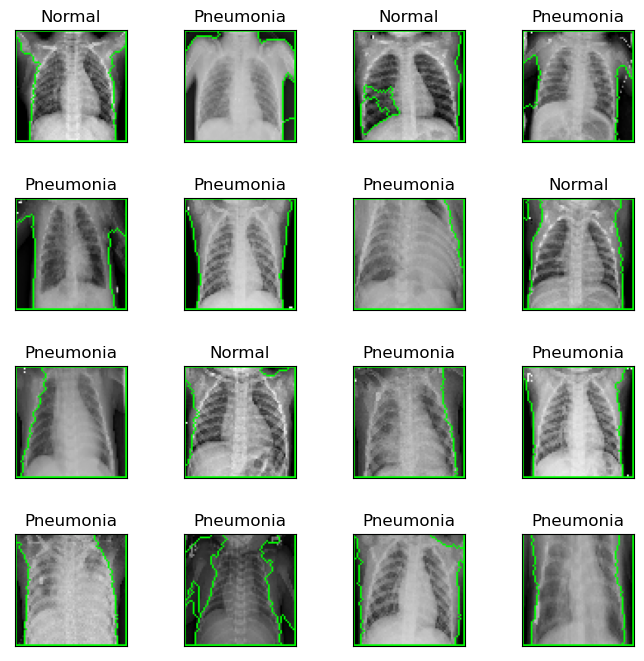

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [12]:
# !pip install --upgrade tensorflow protobuf
!pip install protobuf==3.20.0


Looking in indexes: http://pypi.douban.com/simple
  Using cached http://pypi.doubanio.com/packages/5c/a6/9a451d69492a695e2300643933590762aa4e5bbef2ae5f08f7d218ea6c3a/protobuf-3.20.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.3
    Uninstalling protobuf-4.23.3:
      Successfully uninstalled protobuf-4.23.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
onnx 1.14.0 requires protobuf>=3.20.2, but you have protobuf 3.20.0 which is incompatible.


In [9]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [10]:
# Normalization of data 
x_train = train_data / 255.
x_test = test_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
test_labels_enc = le.transform(test_labels)

y_train = keras.utils.to_categorical(train_labels_enc, 4)
y_test = keras.utils.to_categorical(test_labels_enc, 4)

print(train_labels_enc[:6], y_train[:6])

NameError: name 'keras' is not defined

In [39]:
# data_augmentation = keras.Sequential(
#     [
# #         layers.Normalization(),
#         tf.keras.layers.experimental.preprocessing.Normalization,
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.1),
#         layers.RandomContrast(factor=0.1),
#         layers.RandomZoom(height_factor=0.2, width_factor=0.2),
#     ],
#     name="data_augmentation",
# )
# # Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)
import tensorflow as tf
from tensorflow.keras import layers

# ... Rest of the code ...

# Define the normalization layer separately
normalization_layer = layers.experimental.preprocessing.Normalization()
normalization_layer.adapt(x_train)

# Define the RandomRotation and RandomZoom layers separately
rotation_layer = layers.experimental.preprocessing.RandomRotation(factor=0.1)
zoom_layer = layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2)

# Apply normalization, rotation, and zoom to the input data before data augmentation
x_train_normalized = normalization_layer(x_train)
x_test_normalized = normalization_layer(x_test)

x_train_augmented = rotation_layer(x_train_normalized)
x_train_augmented = zoom_layer(x_train_augmented)

x_test_augmented = rotation_layer(x_test_normalized)
x_test_augmented = zoom_layer(x_test_augmented)

# Define the data_augmentation pipeline for the remaining augmentations
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomContrast(factor=0.1),
], name="data_augmentation")


# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


# EANet Model

In [53]:
# Hyper-parameters

weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 32
num_epochs = 25
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (INPUT_SHAPE[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 1024


In [59]:
#Implement the patch extraction and encoding layer
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [60]:
#Implement the external attention block
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

#Implement the MLP block
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

#Implement the Transformer block
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [61]:
#Implement EANet Model
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(2, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [62]:
##Train on data
model = get_model(attention_type="external_attention")
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")]
)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
______________________________________________________________________________________

In [50]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Create a new Sequential model
# model = Sequential()

# # Add layers to the model
# model.add(Dense(64, activation='relu', input_shape=(INPUT_SHAPE,)))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(4, activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Now you can train the model as before with y_train_encoded
# history = model.fit(
#     x_train,
#     y_train_encoded,
#     batch_size=batch_size,
#     epochs=num_epochs,
#     validation_split=validation_split,
# )


In [63]:
# history = model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=num_epochs,
#     validation_split=validation_split,
# )

# Compile the model
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")]
)

# Train the model
history = model.fit(
    x_train_augmented,  # Use augmented training data
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/25


ValueError: in user code:

    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/song/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 4))


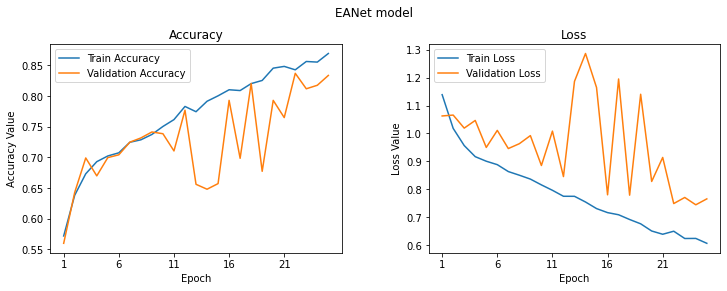

In [62]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('EANet model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('KidneyStoneDetector_EANet.h5')

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks/Kidneystone/KidneyStoneDetector_EANet.h5')

In [63]:
# Model evaluated on training data
score = model.evaluate(x_train, y_train, verbose=0)
print('Training score:', score[0])
print('Training accuracy:', score[1] * 100)

Training score: 0.7482829093933105
Training accuracy: 83.7022602558136


In [64]:
# Model evaluated on testing data
score= model.evaluate(x_test, y_test, verbose=0)
print('Testing score:', score[0])
print('Testing accuracy:', score[1] * 100)

Testing score: 0.7475196719169617
Testing accuracy: 83.64998698234558


In [65]:
y_pre_test=model.predict(x_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
categories = ['Cyst','Normal', 'Stone','Tumor']
test_labels_enc[:6], y_pre_test[:6]

(array([1, 1, 0, 1, 1, 2]), array([1, 1, 0, 1, 1, 0]))

In [66]:
clf_report = pd.DataFrame(classification_report(test_labels_enc, y_pre_test,target_names=categories, output_dict=True))
cm = confusion_matrix(test_labels_enc, y_pre_test)
print("Test Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(test_labels_enc, y_pre_test) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")

Test Result:
Accuracy Score: 83.65%
_______________________________________________
CLASSIFICATION REPORT:
                  Cyst       Normal       Stone       Tumor  accuracy  \
precision     0.729766     0.980014    0.700535    0.811927    0.8365   
recall        0.995438     0.872854    0.314149    0.815668    0.8365   
f1-score      0.842146     0.923336    0.433775    0.813793    0.8365   
support    1096.000000  1573.000000  417.000000  651.000000    0.8365   

             macro avg  weighted avg  
precision     0.805560      0.846153  
recall        0.749527      0.836500  
f1-score      0.753262      0.825813  
support    3737.000000   3737.000000  


In [67]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import seaborn as sn
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    #y_score = clf.decision_function(X_test)
    y_score=model.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sn.despine()
    plt.show()

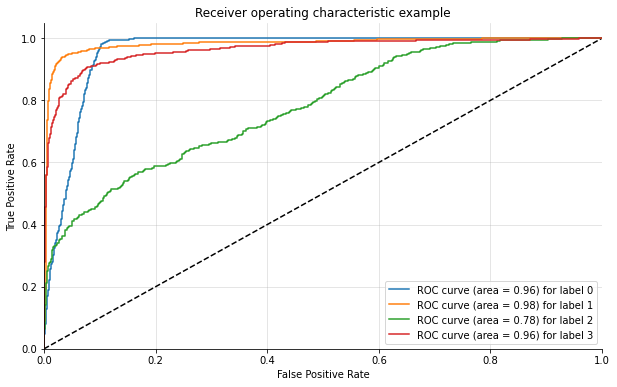

In [68]:
plot_multiclass_roc(model, x_test, test_labels_enc, n_classes=4, figsize=(10, 6))

In [69]:
# ROC AUC scores
y_pred=model.predict(x_test)
macro_roc_auc_ovo = roc_auc_score(test_labels_enc, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(test_labels_enc, y_pred, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(test_labels_enc,y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_labels_enc, y_pred, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.918325 (macro),
0.926238 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.920873 (macro),
0.949423 (weighted by prevalence)


In [70]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

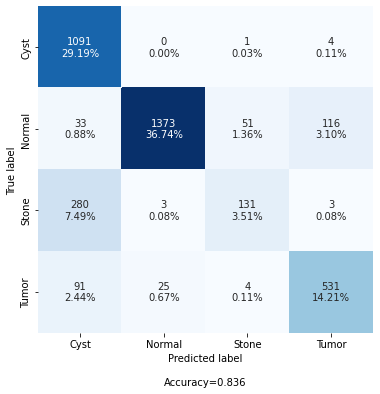

In [71]:
# Cyst = 0 ,  Normal =1  , Stone =2 , Tumor = 3
categories = ['Cyst','Normal', 'Stone','Tumor']
make_confusion_matrix(cm, categories=categories,figsize=(6,6), cbar=False)
plt.savefig("ConfusionMatrix.png")